# Find one shortest path

Focus on only the adelaide area. Return the full shortest path dictionary. 

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
# import geoplot
from pysal.lib import weights
import networkx as nx
from scipy.spatial import distance

In [8]:
## read files

# read dfs
trans_mcc_df = pd.read_pickle("../../data_process/trans_mcc_df.pkl")
trans_age_df = pd.read_pickle("../../data_process/trans_age_df.pkl")
flow_df = pd.read_pickle("../../data_process/flow_df.pkl")

# read spatial files
sa2_south_au = gpd.read_file("../../data_process/shapefiles/sa2_south_au.shp")
sa2_adelaide = gpd.read_file('../../data_process/shapefiles/sa2_adelaide.shp')

# read road networks
sa2_roads = gpd.read_file("../../data_process/shapefiles/sa2_roads.shp")

# read job and income data
jobs_all=pd.read_pickle("../../data_process/jobs_all.pkl")
jobs_industries=pd.read_pickle("../../data_process/jobs_industries.pkl")


In [9]:
# convert to Australia projection
sa2_adelaide_proj = sa2_adelaide.to_crs("epsg:3112")
sa2_adelaide_proj.crs

<Projected CRS: EPSG:3112>
Name: GDA94 / Geoscience Australia Lambert
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Australia - Australian Capital Territory; New South Wales; Northern Territory; Queensland; South Australia; Tasmania; Western Australia; Victoria.
- bounds: (112.85, -43.7, 153.69, -9.86)
Coordinate Operation:
- name: Geoscience Australia Standard National Scale Lambert Projection
- method: Lambert Conic Conformal (2SP)
Datum: Geocentric Datum of Australia 1994
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

# Build Physical Network with Euclidean Weights

1. Generate a Queen net.
2. Use Kernel to create the Euclidean distance matrix for weighting.
3. Assign the Euclidean distance matrix to the Queen network.

In [12]:
# Step 1. Queen net
adelaide_queen=weights.contiguity.Queen.from_dataframe(sa2_adelaide_proj)
print(adelaide_queen.n)


110


/usr/local/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 103.
  warnings.warn(message)


In [13]:
adelaide_queen.weights

{0: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0],
 9: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 10: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 11: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 12: [1.0, 1.0, 1.0, 1.0, 1.0],
 13: [1.0, 1.0, 1.0, 1.0],
 14: [1.0, 1.0, 1.0, 1.0, 1.0],
 15: [1.0, 1.0, 1.0, 1.0, 1.0],
 16: [1.0, 1.0, 1.0, 1.0, 1.0],
 17: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 18: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 19: [1.0, 1.0, 1.0, 1.0],
 20: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 21: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 22: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 23: [1.0, 1.0, 1.0, 1.0, 1.0],
 24: [1.0, 1.0, 1.0],
 25: [1.0, 1.0, 1.0, 1.0],
 26: [1.0, 1.0, 1.0],
 27: [1.0, 1.0, 1.0, 1.0, 1.0],
 28: [1.0, 1.0, 1.0, 1.0

In [14]:
# Step 2. Kernel net with the right euclidean weighting
# use all the K nearest neighbors! 
sa2_adelaide_kernel=weights.distance.Kernel.from_dataframe(sa2_adelaide_proj, k=109) 

# turn the defaults to euclidean distances as weights.
for i in sa2_adelaide_kernel.neighbors.keys():
    for j_idx in range(len(sa2_adelaide_kernel.neighbors[i])):
        j = sa2_adelaide_kernel.neighbors[i][j_idx]
        # note that kw.weights indices are 
        # i (node index), j_idx (index of the node on the list - not node index!)
        weight = sa2_adelaide_kernel.weights[i][j_idx]
        distance = (1 - weight)*sa2_adelaide_kernel.bandwidth[i]
        sa2_adelaide_kernel.weights[i][j_idx] = distance[0]
        
# show the weights
sa2_adelaide_kernel.weights


{0: [41698.538472576256,
  39421.08926227119,
  30497.116672444663,
  25618.632095717752,
  31705.822674111838,
  24494.457312259517,
  25709.060205318932,
  25591.90807555968,
  22809.321899060516,
  21999.96860849775,
  20127.801404996804,
  22025.118735507378,
  19460.431650304676,
  16907.405595692842,
  17927.3329843908,
  14133.58594147347,
  12239.17863823791,
  10786.195096737238,
  9543.769084991978,
  8093.6097489007625,
  9572.978103581072,
  5601.289182392765,
  6653.12587493392,
  7924.37727335922,
  5723.084863839656,
  8537.74656627394,
  8767.324420381747,
  15586.598065985407,
  17605.84100485652,
  13295.46462724046,
  16558.6316049065,
  13065.206485542376,
  10701.371192536715,
  8266.980668602488,
  5752.265532023589,
  5743.4392774014705,
  6351.69114857795,
  0.0,
  3181.015859367035,
  3249.520475685342,
  3154.2012667919753,
  11217.357191500207,
  3104.7205526370817,
  8813.764994783365,
  3818.510707690052,
  22177.003145651932,
  6231.060742561149,
  6509.35

In [15]:
# Step 3. assign euclidean weights to Queen net
for o in adelaide_queen.neighbors.keys():
#     print(o)
    for d_idx in range(len(adelaide_queen.neighbors[o])):
        d = adelaide_queen.neighbors[o][d_idx] # return the o and d SA2 original indices. 
        weight = sa2_adelaide_kernel[o][d] # get the kernel weight associated with the o and d.
        adelaide_queen.weights[o][d_idx] = weight

adelaide_queen.weights

{0: [2277.5537834445727,
  5601.289182392765,
  3154.2012667919753,
  3818.510707690052,
  3104.7205526370817,
  3675.0039315884505,
  4232.016532923088,
  3181.015859367035,
  3249.520475685342,
  4614.180816026],
 1: [2277.5537834445727,
  3000.347774932703,
  2712.6142456973935,
  2633.3156625268853,
  3428.5866248756915,
  2881.506150372216],
 2: [15745.119089807597,
  15359.047903711138,
  31086.13015009922,
  17798.39793256109,
  13834.668366197066,
  15963.528413690421,
  13858.610038897383,
  14472.164435630906],
 3: [8119.390262702306,
  8972.451043567717,
  7738.53239380151,
  16217.820148840641,
  10419.684177388559,
  12430.570604269451,
  11764.107969860277],
 4: [7738.53239380151,
  17862.026297459674,
  8294.240723560837,
  11652.927647792385,
  11648.444751114304],
 5: [15359.047903711138,
  16217.820148840641,
  17862.026297459674,
  13318.423339793426,
  16019.525505808977,
  10031.554660454956,
  11850.002697179507],
 6: [5962.785320355493,
  8294.240723560837,
  133

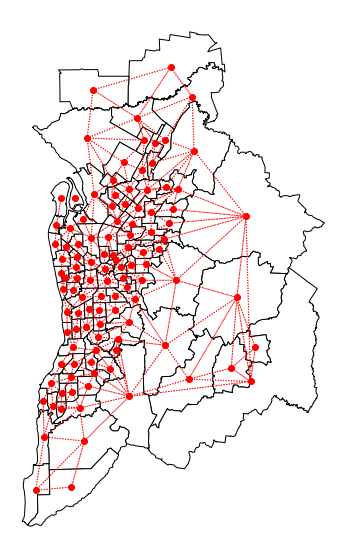

In [16]:
# vis the basic network connection in adelaide
# very dense in the middle
ax = sa2_adelaide_proj.plot(edgecolor='k', facecolor='w', figsize = (10,10))
sa2_adelaide_proj.centroid.plot(ax = ax, facecolor='r')
adelaide_queen.plot(sa2_adelaide_proj, ax = ax, 
                  edge_kws=dict(color='r', linestyle=':', linewidth=1),
                  node_kws=dict(marker=''))
ax.set_axis_off()

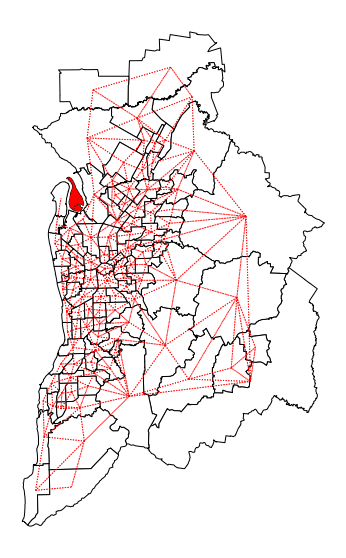

In [10]:
# visualize with one SA2 highlighted.
idx=103 # Torrens Island. 
one_example = gpd.GeoSeries(sa2_adelaide_proj.loc[idx, 'geometry'])

ax = sa2_adelaide_proj.plot(edgecolor='k', facecolor='w', figsize = (10,10))
one_example.plot(ax = ax, facecolor='r')
adelaide_queen.plot(sa2_adelaide_proj, ax = ax, 
                  edge_kws=dict(color='r', linestyle=':', linewidth=1),
                  node_kws=dict(marker=''))

ax.set_axis_off()

In [17]:
# create the queen network in nx
adelaide_nx = adelaide_queen.to_networkx()

# assign weights to adelaide_nx
for o,d in adelaide_nx.edges:
    adelaide_nx.edges[o,d]['weight'] = adelaide_queen[o][d]

# example weight between nodes 0 and 1.
adelaide_nx.get_edge_data(0, 1)


{'weight': 2277.5537834445727}

# Examples of the shortest path.

Paths from origin to destination.

In [18]:
# find the shortest path
path = nx.shortest_path(adelaide_nx, source = 1, target = 80, weight = 'weight')
print(path)


[1, 0, 22, 68, 70, 66, 77, 81, 80]


In [19]:
# create the path
from shapely.geometry import LineString
path_edge_list = []

for node_idx in range(len(path)-1):
    edge = LineString([sa2_adelaide_proj.centroid[path[node_idx]],sa2_adelaide_proj.centroid[path[node_idx+1]]]) 
    path_edge_list.append(edge)

path_edge_geo = gpd.GeoSeries(path_edge_list)

path_edge_geo

0    LINESTRING (418661.427 -3937155.968, 419063.22...
1    LINESTRING (419063.221 -3939397.800, 417930.70...
2    LINESTRING (417930.709 -3942370.388, 417613.63...
3    LINESTRING (417613.631 -3944964.419, 417655.75...
4    LINESTRING (417655.759 -3947544.089, 417347.26...
5    LINESTRING (417347.264 -3949960.699, 416867.64...
6    LINESTRING (416867.646 -3952510.726, 416050.01...
7    LINESTRING (416050.010 -3954690.367, 416646.64...
dtype: geometry

In [20]:
# 


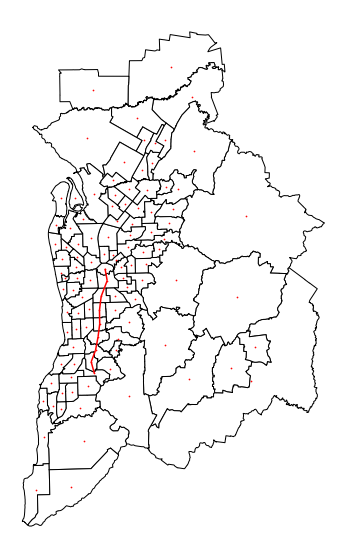

In [21]:
# visual
ax = sa2_adelaide_proj.plot(edgecolor='k', facecolor='w', figsize = (10,10))
sa2_adelaide_proj.centroid.plot(ax = ax, facecolor='r', markersize = 0.5)
path_edge_geo.plot(ax = ax, color = 'r')
# adelaide_queen.plot(sa2_adelaide_proj, ax = ax, 
#                   #edge_kws=dict(color='r', linestyle=':', linewidth=1),
#                   node_kws=dict(marker=''))
ax.set_axis_off()


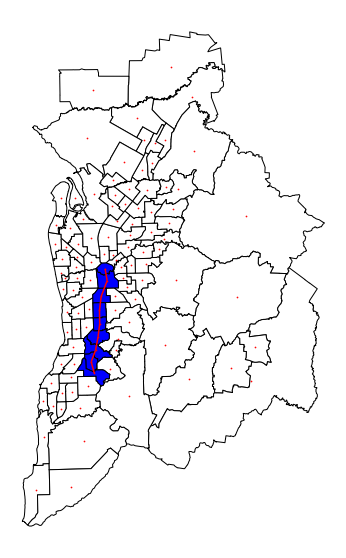

In [16]:
# visual
ax = sa2_adelaide_proj.plot(edgecolor='k', facecolor='w', figsize = (10,10))
sa2_adelaide_proj.loc[path,:].plot(ax=ax, edgecolor='k', facecolor='b')
sa2_adelaide_proj.centroid.plot(ax = ax, facecolor='r', markersize = 0.5)
path_edge_geo.plot(ax = ax, color = 'r')
# adelaide_queen.plot(sa2_adelaide_proj, ax = ax, 
#                   #edge_kws=dict(color='r', linestyle=':', linewidth=1),
#                   node_kws=dict(marker=''))
ax.set_axis_off()

In [22]:
# Another pair of shortest path
# find the shortest path
path = nx.shortest_path(adelaide_nx, source = 6, target = 100, weight = 'weight')
print(path)

[6, 4, 3, 11, 12, 0, 93, 97, 101, 99, 100]


In [23]:
# create the path
from shapely.geometry import LineString
path_edge_list = []

for node_idx in range(len(path)-1):
    edge = LineString([sa2_adelaide_proj.centroid[path[node_idx]],sa2_adelaide_proj.centroid[path[node_idx+1]]]) 
    path_edge_list.append(edge)

path_edge_geo = gpd.GeoSeries(path_edge_list)

path_edge_geo

0    LINESTRING (442414.041 -3955834.746, 434391.68...
1    LINESTRING (434391.684 -3957940.977, 429990.74...
2    LINESTRING (429990.745 -3951575.711, 424214.41...
3    LINESTRING (424214.417 -3942903.695, 422716.69...
4    LINESTRING (422716.698 -3940508.263, 419063.22...
5    LINESTRING (419063.221 -3939397.800, 416078.21...
6    LINESTRING (416078.212 -3935879.223, 413649.93...
7    LINESTRING (413649.938 -3932587.718, 412039.69...
8    LINESTRING (412039.698 -3929497.794, 409522.28...
9    LINESTRING (409522.281 -3928834.610, 410375.12...
dtype: geometry

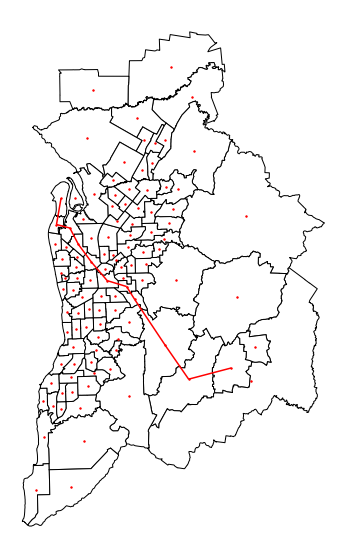

In [24]:
# visualize
ax = sa2_adelaide_proj.plot(edgecolor='k', facecolor='w', figsize = (10,10))
sa2_adelaide_proj.centroid.plot(ax = ax, facecolor='r', markersize = 2)
path_edge_geo.plot(ax = ax, color = 'r')
# adelaide_queen.plot(sa2_adelaide_proj, ax = ax, 
#                   #edge_kws=dict(color='r', linestyle=':', linewidth=1),
#                   node_kws=dict(marker=''))
ax.set_axis_off()


# Full shortest paths

In [25]:
# full paths.
# return: (node, (distance, path))
path=dict(nx.all_pairs_dijkstra(adelaide_nx, weight='weight'))

In [26]:
# sw: this returns the shortest paths from node 0 to all other nodes. 
print(len(path[0][1].keys()))
path[0][1]

109


{0: [0],
 1: [0, 1],
 12: [0, 12],
 16: [0, 16],
 18: [0, 18],
 21: [0, 21],
 22: [0, 22],
 23: [0, 23],
 93: [0, 93],
 107: [0, 107],
 108: [0, 108],
 20: [0, 1, 20],
 10: [0, 16, 10],
 17: [0, 18, 17],
 91: [0, 108, 91],
 104: [0, 108, 104],
 106: [0, 108, 106],
 58: [0, 22, 58],
 68: [0, 22, 68],
 69: [0, 23, 69],
 11: [0, 12, 11],
 37: [0, 21, 37],
 19: [0, 21, 19],
 90: [0, 93, 90],
 97: [0, 93, 97],
 102: [0, 1, 20, 102],
 35: [0, 1, 20, 35],
 14: [0, 18, 17, 14],
 15: [0, 18, 17, 15],
 57: [0, 107, 57],
 62: [0, 22, 58, 62],
 92: [0, 108, 106, 92],
 105: [0, 108, 106, 105],
 109: [0, 108, 104, 109],
 61: [0, 22, 68, 61],
 70: [0, 22, 68, 70],
 65: [0, 23, 69, 65],
 9: [0, 16, 10, 9],
 3: [0, 12, 11, 3],
 95: [0, 108, 91, 95],
 94: [0, 93, 90, 94],
 36: [0, 21, 37, 36],
 51: [0, 18, 17, 14, 51],
 52: [0, 21, 37, 52],
 39: [0, 21, 37, 36, 39],
 48: [0, 1, 20, 35, 48],
 66: [0, 22, 68, 70, 66],
 13: [0, 18, 17, 14, 13],
 64: [0, 22, 58, 62, 64],
 101: [0, 93, 97, 101],
 38: [0, 1, 

In [27]:
# create a OD dictionary.
OD_full_path = {}

for o in range(110):
    for d in range(110):
        if d==103 or o==103: # note that 103 is the island - this is no path to it.
            pass
        else:
            OD_full_path[(o,d)] = path[o][1][d]

In [28]:
OD_full_path[(0,10)]

[0, 16, 10]

In [29]:
OD_full_path[(10,0)]

[10, 16, 0]

In [30]:
import pickle

with open("../../data_process/OD_full_path_dic.pickle", 'wb') as f:
    pickle.dump(OD_full_path, f, protocol=pickle.HIGHEST_PROTOCOL)